In [1]:
import warnings
warnings.filterwarnings("ignore")

# Run for each Explainer

In [ ]:
import os
from collections import defaultdict

from tqdm import tqdm
from PIL import Image, ImageFilter

import torch
import numpy as np
import pandas as pd

from captum.attr import (
    IntegratedGradients,
    Saliency,
    DeepLift,
    Occlusion,
    LayerGradCam,
    GuidedGradCam,
    Deconvolution,
    GradientShap,
    DeepLiftShap,
    Lime,
    LayerAttribution,
)
from captum.metrics import sensitivity_max, infidelity

from skimage.segmentation import slic

from utils.utils import create_folder, load_config
from dataloaders.presets import PresetTransform
from models import *

def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.1, inputs.shape)).float().to(inputs.device)
    return noise, torch.clip(inputs - noise, 0, 1)

def rgb_to_gray_and_scale(x):
    x = np.asarray(x)
    # Shape must be in (H, W, C)
    x_combined = np.sum(x, axis=2)
    x_combined = (x_combined > 0) * x_combined

    sorted_vals = np.sort(np.abs(x_combined).flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id: int = np.where(cum_sums >= cum_sums[-1] * 0.01 * 98)[0][0]
    threshold = sorted_vals[threshold_id]

    attr_norm = x_combined / threshold
    
    return np.clip(attr_norm, 0, 1) # only positive for pain class

# --- Create superpixel feature mask for Captum ---
def make_feature_mask(img_tensor, n_segments=100):
    x = img_tensor.detach().cpu().squeeze(0)  # 3 x H x W
    x_np = x.numpy()
    x_np = (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-8)
    x_np = np.transpose(x_np, (1, 2, 0))  # H, W, 3

    seg = slic(x_np, n_segments=n_segments, compactness=10.0, sigma=0.0,
               start_label=0, channel_axis=2)

    seg_t = torch.from_numpy(seg).long().unsqueeze(0).unsqueeze(0)
    return seg_t, seg

# ------------------------------------------------------------------------------

device = 'cuda'
model_name = 'NCNN'
path_experiments = os.path.join('experiments', model_name)

# ------------------------------------------------------------------------------

def resolve_experiment(exp_name: str, device: torch.device):
    if "NCNN" in exp_name:
        model = NCNN().to(device)
        return {
            "model": model,
            "img_size": 120,
            "transform": PresetTransform("NCNN").transforms,
            "layer": model.merge_branch[0],
            "model_name": exp_name,
        }
    if "VGGFace" in exp_name:
        model = VGGFace().to(device)
        return {
            "model": model,
            "img_size": 224,
            "transform": PresetTransform("VGGFace").transforms,
            "layer": model.VGGFace.features.conv5_3,
            "model_name": exp_name,
        }
    if "ViT" in exp_name:
        model = ViT().to(device)
        return {
            "model": model,
            "img_size": 224,
            "transform": PresetTransform("ViT").transforms,
            "layer": model.ViT.conv_proj,
            "model_name": exp_name,
        }
    return None


def ensure_feature_mask(ctx: dict, n_segments: int = 100):
    if "feature_mask" not in ctx:
        mask, _ = make_feature_mask(ctx["input"], n_segments=n_segments)
        ctx["feature_mask"] = mask.to(ctx["device"]).contiguous()
    return ctx["feature_mask"]


# explainer catalogue ----------------------------------------------------------

EXPLAINER_SPECS = [
    (
        "IntegratedGradients",
        {
            "factory": lambda model, layer: IntegratedGradients(model),
            "prepare": lambda ctx: {"attribute": {"internal_batch_size": 10}},
        },
    ),
    (
        "Saliency",
        {
            "factory": lambda model, layer: Saliency(model),
        },
    ),
    (
        "DeepLift",
        {
            "factory": lambda model, layer: DeepLift(model),
            "prepare": lambda ctx: {"attribute": {"baselines": ctx["blurred"]}},
        },
    ),
    (
        "Occlusion",
        {
            "factory": lambda model, layer: Occlusion(model),
            "prepare": lambda ctx: {
                "attribute": {
                    "sliding_window_shapes": (3, 20, 20),
                    "strides": (3, 10, 10),
                }
            },
        },
    ),
    (
        "GradCAM",
        {
            "factory": lambda model, layer: LayerGradCam(model, layer),
            "postprocess": lambda attr, ctx: LayerAttribution.interpolate(
                attr, ctx["target_shape"], interpolate_mode="bilinear"
            ).repeat(1, 3, 1, 1),
        },
    ),
    (
        "GuidedGradCAM",
        {
            "factory": lambda model, layer: GuidedGradCam(model, layer),
        },
    ),
    (
        "Deconvolution",
        {
            "factory": lambda model, layer: Deconvolution(model),
        },
    ),
    (
        "GradientShap",
        {
            "factory": lambda model, layer: GradientShap(model),
            "prepare": lambda ctx: {
                "attribute": {
                    "baselines": torch.zeros_like(ctx["input"]),
                    "n_samples": 5,
                    "stdevs": 0.0,
                }
            },
        },
    ),
    (
        "DeepLiftShap",
        {
            "factory": lambda model, layer: DeepLiftShap(model),
            "prepare": lambda ctx: {
                "attribute": {"baselines": ctx["blurred"].repeat(5, 1, 1, 1)}
            },
        },
    ),
    (
        "Lime",
        {
            "factory": lambda model, layer: Lime(model),
            "prepare": lambda ctx: {
                "attribute": {
                    "baselines": torch.zeros_like(ctx["input"]),
                    "feature_mask": ensure_feature_mask(ctx),
                    "n_samples": 500,
                    "perturbations_per_eval": 64,
                    "show_progress": False,
                }
            },
        },
    ),
]


# main pipeline ----------------------------------------------------------------

all_data = defaultdict(list)

for exp in os.listdir(path_experiments):
    if any(ext in exp for ext in (".pkl", "masks", ".png", ".pdf")):
        continue

    experiment_cfg = resolve_experiment(exp, device)
    if experiment_cfg is None:
        continue

    model = experiment_cfg["model"]
    img_size = experiment_cfg["img_size"]
    transform = experiment_cfg["transform"]
    layer = experiment_cfg["layer"]

    path_model = os.path.join(path_experiments, exp, "Model", "best_model.pt")
    path_yaml = os.path.join(path_experiments, exp, "Model", "config.yaml")
    config = load_config(path_yaml)
    test_path = config["path_test"]

    state_dict = torch.load(path_model, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    explainers = {name: spec["factory"](model, layer) for name, spec in EXPLAINER_SPECS}

    image_files = [f for f in os.listdir(test_path) if f.lower().endswith(".jpg")]
    for image_file in tqdm(image_files):
        full_img_path = os.path.join(test_path, image_file)

        img_rgb = Image.open(full_img_path).convert("RGB")
        img_rgb = img_rgb.resize((img_size, img_size))
        img_name = os.path.splitext(image_file)[0]
        label = 1 if img_name.split("_")[3] == "pain" else 0

        if "VGGFace" in exp:
            img_input = Image.fromarray(np.array(img_rgb)[:, :, ::-1])
        else:
            img_input = img_rgb

        blurred_image = img_input.filter(ImageFilter.GaussianBlur(radius=5))

        transformed = transform(img_input)
        transformed_blurred = transform(blurred_image)

        base_input = transformed.unsqueeze(0).to(device)
        base_blurred = transformed_blurred.unsqueeze(0).to(device)

        ctx_base = {
            "device": device,
            "target_shape": (img_size, img_size),
            "input_base": base_input,
            "blurred": base_blurred,
        }

        for XAI_name, spec in EXPLAINER_SPECS:
            explainer = explainers[XAI_name]

            method_ctx = dict(ctx_base)
            method_ctx["input"] = (
                ctx_base["input_base"].clone().detach().requires_grad_(True)
            )

            if XAI_name == "Lime" or XAI_name == "DeepLift":
                method_ctx["input"] = (
                    ctx_base["input_base"].clone().detach().requires_grad_(True).contiguous()
            )

            spec_kwargs = spec.get("prepare", lambda ctx: {})(method_ctx)
            attr_kwargs = spec_kwargs.get("attribute", {})
            sensitivity_kwargs = dict(attr_kwargs)
            sensitivity_kwargs.update(spec_kwargs.get("sensitivity", {}))
            infidelity_kwargs = spec_kwargs.get("infidelity", {}).copy()
            infidelity_kwargs.setdefault("normalize", True)

            attributions = explainer.attribute(method_ctx["input"], **attr_kwargs)

            if "postprocess" in spec:
                attributions = spec["postprocess"](attributions, method_ctx)

            sens = sensitivity_max(
                explainer.attribute, method_ctx["input"], **sensitivity_kwargs
            )
            infid = infidelity(
                model,
                perturb_fn,
                method_ctx["input"],
                attributions,
                **infidelity_kwargs,
            )

            attributions_np = (
                attributions.squeeze(0)
                .detach()
                .cpu()
                .numpy()
                .transpose(1, 2, 0)
            )
            attributions_normalized = rgb_to_gray_and_scale(attributions_np)

            output_dir = os.path.join("RGU", model_name, XAI_name)
            create_folder(output_dir)
            output_path = os.path.join(output_dir, f"{img_name}.npz")
            np.savez_compressed(output_path, mask=attributions_normalized)

            all_data["img_path"].append(full_img_path)
            all_data["fold"].append(os.path.basename(os.path.dirname(test_path)))
            all_data["label"].append(label)
            all_data["sensitivity"].append(float(sens))
            all_data["infidelity"].append(float(infid))
            all_data["mask_path"].append(output_path)

            with torch.no_grad():
                probs = model.predict(ctx_base["input_base"])
            pred = (probs >= 0.5).int()
            all_data["probability"].append(float(probs))
            all_data["prediction"].append(int(pred))
            all_data["XAI_name"].append(XAI_name)

dataframe = pd.DataFrame(all_data)
create_folder(os.path.join("RGU", model_name))
dataframe.to_csv(os.path.join("RGU", model_name, "explainers.csv"), index=False)

 20%|██        | 10/50 [02:27<09:46, 14.66s/it]

In [ ]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

TARGET_SIZE = (224, 224)
mask_dir = Path(r"RGU\NCNN\IntegratedGradients")
csv_path = Path(r"RGU\NCNN\IntegratedGradients.csv")
img_root = csv_path.parent

def load_image(img_path: Path, size=TARGET_SIZE) -> np.ndarray:
    with Image.open(img_path) as img:
        return np.array(
            img.convert("RGB").resize(size, Image.Resampling.BILINEAR)
        )

def load_mask(npz_path: Path, size=TARGET_SIZE) -> np.ndarray:
    with np.load(npz_path) as data:
        mask = (
            data["mask"]
            if "mask" in data
            else data["arr_0"]
            if "arr_0" in data
            else data[next(iter(data.keys()))]
        )

    mask = np.where(np.isfinite(mask), mask, np.nan).astype(np.float32)
    vmin, vmax = np.nanmin(mask), np.nanmax(mask)
    if vmax > vmin:
        mask = (mask - vmin) / (vmax - vmin)

    mask_img = Image.fromarray(mask)
    mask_resized = np.array(
        mask_img.resize(size, Image.Resampling.BILINEAR), dtype=np.float32
    )
    return np.nan_to_num(mask_resized)

def resolve_image_path(relative_or_absolute: str) -> Path:
    p = Path(relative_or_absolute)
    return p

meta = pd.read_csv(csv_path)
if "img_path" not in meta.columns:
    raise KeyError("Column 'img_path' not found in CSV")

img_lookup = {
    resolve_image_path(path).stem: resolve_image_path(path)
    for path in meta["img_path"].dropna()
}

npz_paths = sorted(mask_dir.glob("*.npz"))
if not npz_paths:
    raise FileNotFoundError(f"No .npz files found in {mask_dir}")

random.seed(0)
sample_paths = random.sample(npz_paths, k=min(20, len(npz_paths)))

cols = 5
rows = int(np.ceil(len(sample_paths) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.5 * rows))
axes = np.atleast_2d(axes)

for ax, mask_path in zip(axes.flat, sample_paths):
    img_path = img_lookup.get(mask_path.stem)
    if img_path is None or not img_path.exists():
        ax.text(
            0.5,
            0.5,
            f"Image for {mask_path.stem} not found",
            ha="center",
            va="center",
            wrap=True,
        )
        ax.axis("off")
        continue

    img = load_image(img_path)
    mask = load_mask(mask_path)

    ax.imshow(img)
    ax.imshow(mask, cmap="inferno", alpha=0.45)
    ax.set_title(mask_path.stem, fontsize=9)
    ax.axis("off")

for ax in axes.flat[len(sample_paths) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()


# XAI Analysis


## Sensitivity and Infidelity

In [ ]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path_NCNN = "RGU\\XAI Explainers\\NCNN\\explainers.csv"
path_VGG = "RGU\\XAI Explainers\\VGGFace\\explainers.csv"
path_ViT = "RGU\\XAI Explainers\\ViT_B_32\\explainers.csv"

In [ ]:
NCNN_df = pd.read_csv(path_NCNN)
VGG_df = pd.read_csv(path_VGG)
ViT_df = pd.read_csv(path_ViT)

In [ ]:
NCNN_df

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=NCNN_df, y='sensitivity', x='explainer', hue='label')
plt.xticks(rotation=90)

plt.subplot(122)
sns.barplot(data=NCNN_df, y='infidelity', x='explainer', hue='label')
plt.xticks(rotation=90)


In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=VGG_df, y='sensitivity', x='explainer', hue='label')
plt.xticks(rotation=90)
plt.subplot(122)
sns.barplot(data=VGG_df, y='infidelity', x='explainer', hue='label')
plt.xticks(rotation=90)


In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=ViT_df, y='sensitivity', x='explainer', hue='label')
plt.xticks(rotation=90)

plt.subplot(122)
sns.barplot(data=ViT_df, y='infidelity', x='explainer', hue='label')
plt.xticks(rotation=90)

## Agreement

In [8]:
import numpy as np
from pathlib import Path
from itertools import combinations
import pandas as pd
import glob

def load_masks(xai_dirs, mask_key="mask"):
    """Return {sample_id: {method_name: bool_mask}} for every .npz in the folders."""
    samples = {}
    for xai_dir in map(Path, xai_dirs):
        method = xai_dir.name
        for npz_file in sorted(xai_dir.glob("*.npz")):
            with np.load(npz_file) as archive:
                if mask_key not in archive:
                    raise KeyError(f"{npz_file} missing '{mask_key}' array.")
                mask = archive[mask_key]
            samples.setdefault(npz_file.stem, {})[method] = mask
    return samples

# Function to classify pixels by importance
def get_top_k_pixels(importance_map, k_percent=10):

    # Flatten the map and sort the pixels by importance
    flat_map = importance_map.flatten()
    threshold_value = np.percentile(flat_map, 100 - k_percent)
    top_k_mask = importance_map >= threshold_value

    return top_k_mask.astype('int')

def feature_agreement(mask_1, mask_2):
    
    mask_1 = get_top_k_pixels(mask_1)
    mask_2 = get_top_k_pixels(mask_2)

    # Compute the Intersection
    intersection = np.logical_and(mask_1, mask_2)
    union = np.logical_or(mask_1, mask_2)

    # Calculate Feature Agreement
    feature_agreement = np.sum(intersection) / np.sum(union)

    return feature_agreement

def pairwise_iou_agreement(samples):
    """Build a DataFrame with IoU per sample for every method pair."""
    rows = []
    for sample_id, masks in samples.items():
        methods = sorted(masks)
        for left, right in combinations(methods, 2):
            mask_l, mask_r = masks[left], masks[right]
            if mask_l.shape != mask_r.shape:
                raise ValueError(f"Shape mismatch on '{sample_id}' between {left} and {right}.")
            rows.append(
                dict(sample=sample_id, method_a=left, method_b=right, iou=feature_agreement(mask_l, mask_r))
            )
    return pd.DataFrame(rows)

# Example usage:
xai_dirs = glob.glob("RGU\\XAI Explainers\\VGGFace\\*")
samples = load_masks(xai_dirs, mask_key="mask")
agreements = pairwise_iou_agreement(samples)



In [9]:
agreements.sort_values('iou', ascending=False)

,sample,method_a,method_b,iou
13840,ID531_UNIFESP_S48_pain,GradCAM,GuidedGradCAM,0.629750
14452,ID547_UNIFESP_S49_pain,GradCAM,GuidedGradCAM,0.612986
7576,ID369_UNIFESP_S34_pain,GradCAM,GuidedGradCAM,0.558143
16650,ID606_UNIFESP_S54_pain,GradCAM,LIME,0.539840
16540,ID603_UNIFESP_S54_nopain,GradCAM,GuidedGradCAM,0.536671
...,...,...,...,...
2081,ID193_iCOPE_S17_pain,GuidedGradCAM,Saliency,0.000000
2080,ID193_iCOPE_S17_pain,GuidedGradCAM,Occlusion,0.000000
18514,ID88_iCOPE_S08_pain,DeepLift,GuidedGradCAM,0.000000
2079,ID193_iCOPE_S17_pain,GuidedGradCAM,LIME,0.000000


In [10]:
def summarize_pairwise_iou(agreements: pd.DataFrame) -> pd.DataFrame:
    agg = (
        agreements
        .groupby(["method_a", "method_b"])["iou"]
        .agg(mean_iou="mean", std_iou="std", n="count")
        .reset_index()
        .sort_values("mean_iou", ascending=False)
    )
    return agg

summary = summarize_pairwise_iou(agreements)
top_pair = summary.iloc[0]

print(summary)                     # full ranking
print("\nHighest agreement:")
print(top_pair)


               method_a             method_b  mean_iou   std_iou    n
32  IntegratedGradients             Saliency  0.262058  0.039783  521
22         GradientSHAP  IntegratedGradients  0.258311  0.042708  521
11             DeepLift  IntegratedGradients  0.191022  0.026611  521
14             DeepLift             Saliency  0.169781  0.018951  521
9              DeepLift         GradientSHAP  0.162705  0.024189  521
16              GradCAM        GuidedGradCAM  0.160630  0.121933  521
33                 LIME            Occlusion  0.158468  0.083489  521
3         Deconvolution        GuidedGradCAM  0.137526  0.058482  521
25         GradientSHAP             Saliency  0.125408  0.024812  521
19              GradCAM            Occlusion  0.114374  0.084863  521
0         Deconvolution             DeepLift  0.111287  0.018839  521
18              GradCAM                 LIME  0.104226  0.079045  521
12             DeepLift                 LIME  0.099278  0.032429  521
24         GradientS

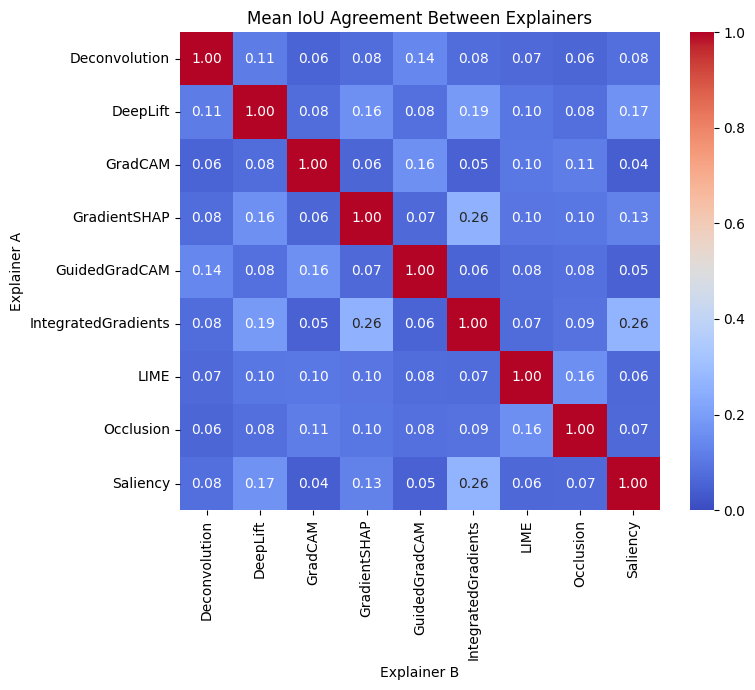

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# assumes `summary` as from summarize_pairwise_iou(agreements)
methods = sorted(set(summary["method_a"]).union(summary["method_b"]))
matrix = summary.pivot(index="method_a", columns="method_b", values="mean_iou").reindex(index=methods, columns=methods)

# mirror upper/lower triangles to fill the diagonal and lower half
matrix = matrix.combine_first(matrix.T)
np.fill_diagonal(matrix.values, 1.0)

plt.figure(figsize=(8, 7))
sns.heatmap(matrix, vmin=0, vmax=1, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Mean IoU Agreement Between Explainers")
plt.ylabel("Explainer A")
plt.xlabel("Explainer B")
plt.tight_layout()
plt.show()


# TCAV

In [1]:
import numpy as np
import os, glob

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

from models import *
from dataloaders import PresetTransform

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):
    return PresetTransform("NCNN").transforms(img)

In [3]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path='RGU\\TCAV\\concepts\\test images\\', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)
    
    return tensors

In [4]:
def assemble_concept(name, id, concepts_path="RGU\\TCAV\\concepts"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

In [5]:
concepts_path = "RGU\\TCAV\\concepts"

closed_eyes_concept = assemble_concept("closed eyes", 0, concepts_path=concepts_path)
open_eyes_concept = assemble_concept("open eyes", 1, concepts_path=concepts_path)
closed_mouth_concept = assemble_concept("closed mouth", 2, concepts_path=concepts_path)
open_mouth_concept = assemble_concept("open mouth", 3, concepts_path=concepts_path)


random_0_concept = assemble_concept("random_0", 4, concepts_path=concepts_path)
random_1_concept = assemble_concept("random_1", 5, concepts_path=concepts_path)

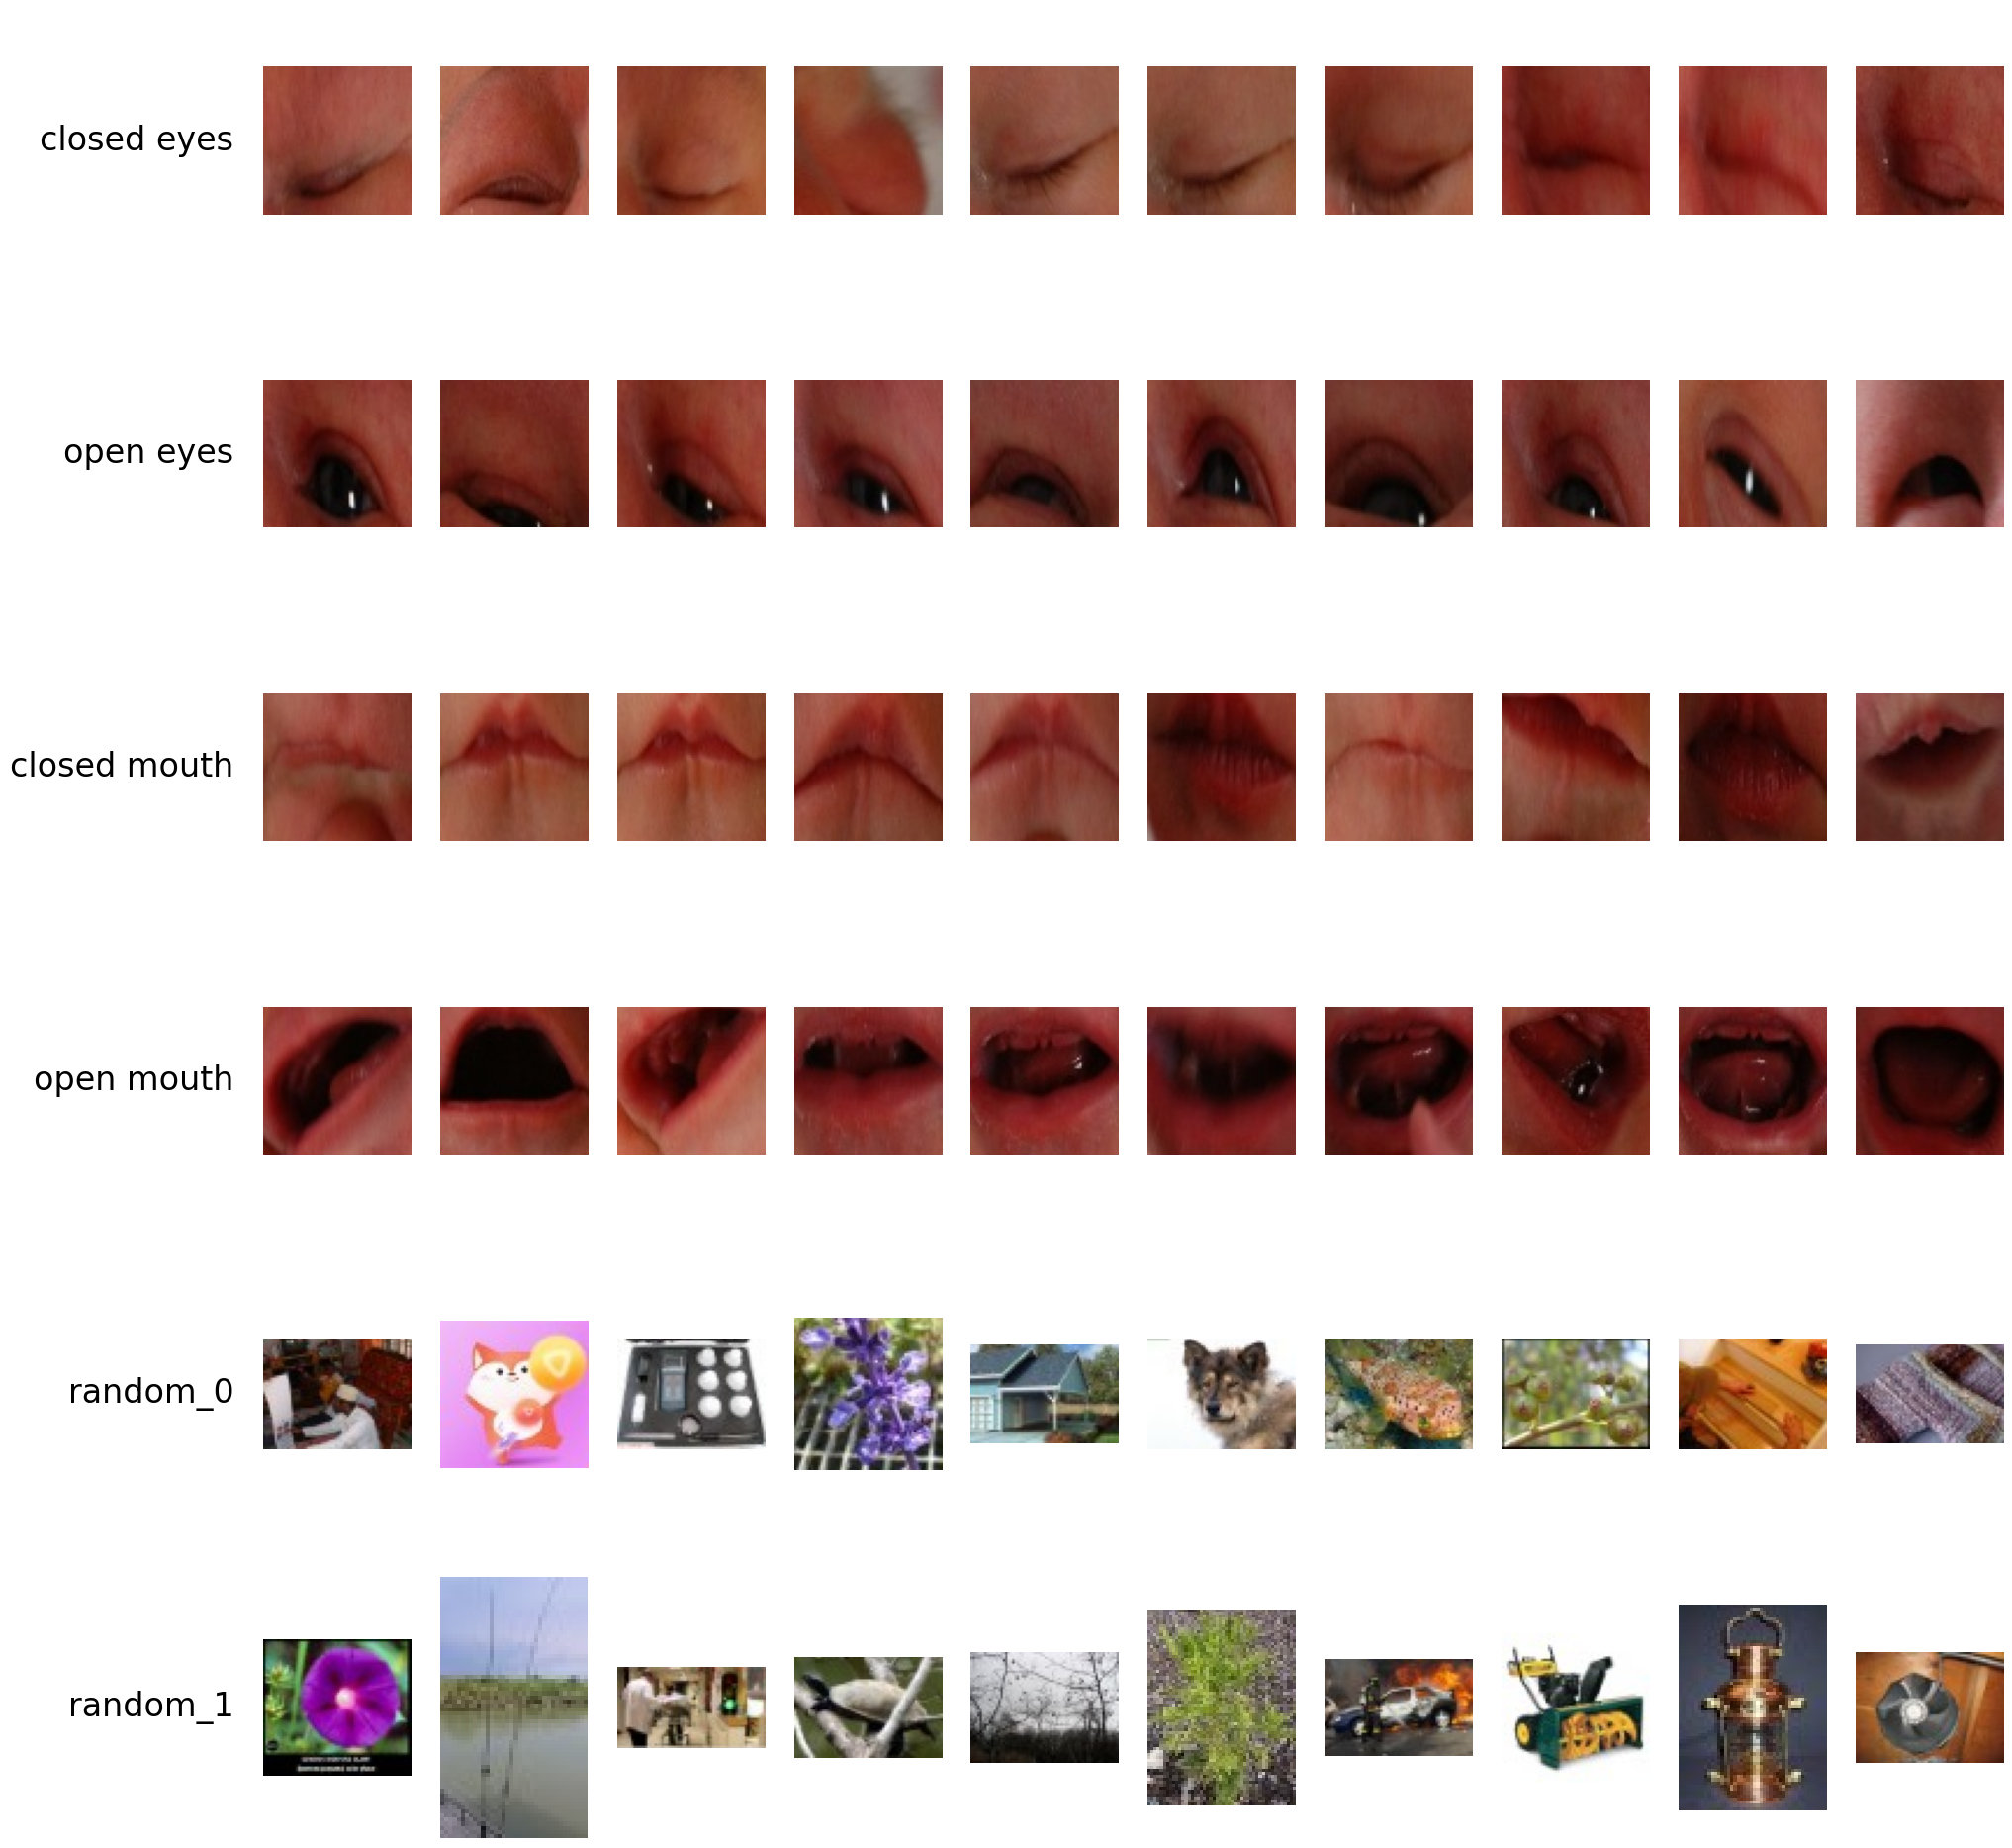

In [6]:
n_figs = 10
n_concepts = 6

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([closed_eyes_concept, open_eyes_concept, closed_mouth_concept, open_mouth_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [7]:
model = NCNN()
model.load_state_dict(torch.load('experiments\\NCNN\\20250718_0744_NCNN\\Model\\best_model.pt'))
model.eval()

NCNN(
  (left_branch): Sequential(
    (0): MaxPool2d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  )
  (center_branch): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (right_branch): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (merge_branch): Sequential(
    (0): Conv2d(131, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [8]:
layers=['merge_branch.2', 'left_branch', 'center_branch', 'right_branch']

mytcav = TCAV(model=model,
              layers=layers)

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\captum\concept\_core\tcav.py:325: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  self.classifier = DefaultClassifier()


In [9]:
experimental_set_rand = [[open_eyes_concept, closed_eyes_concept, open_mouth_concept, closed_mouth_concept, random_0_concept], [open_mouth_concept, closed_mouth_concept, random_1_concept]]

In [10]:
# Load sample images from folder
pain_imgs = load_image_tensors('pain', transform=False)

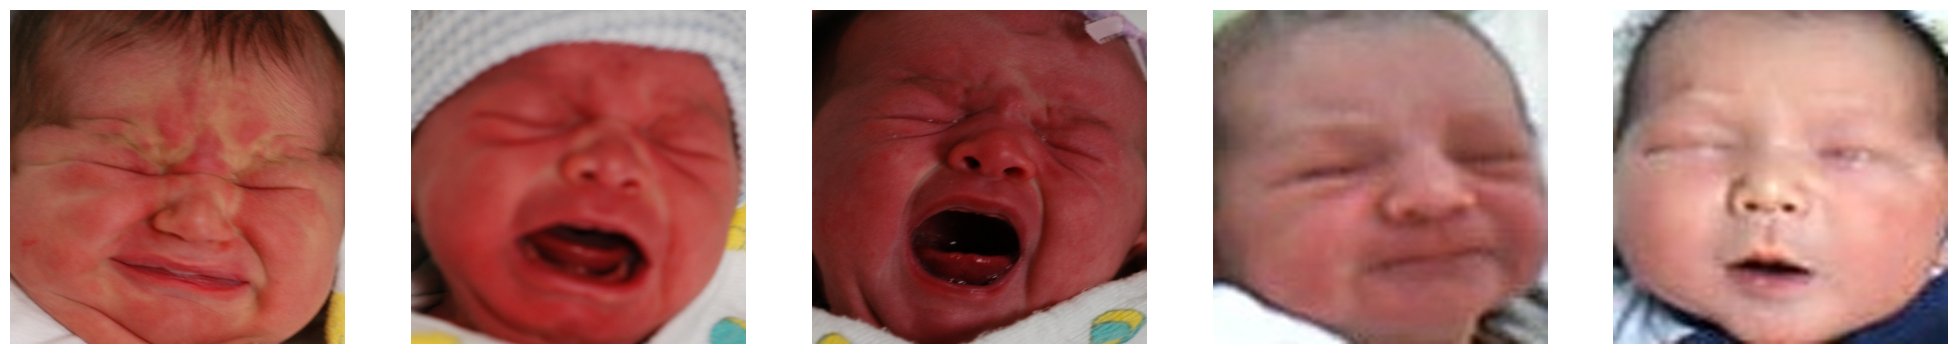

In [11]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(pain_imgs[0])
axs[1].imshow(pain_imgs[1])
axs[2].imshow(pain_imgs[2])
axs[3].imshow(pain_imgs[3])
axs[4].imshow(pain_imgs[4])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [12]:
# Load sample images from folder
pain_tensors = torch.stack([transform(img) for img in pain_imgs])
experimental_set_rand

[[Concept(1, 'open eyes'),
  Concept(0, 'closed eyes'),
  Concept(3, 'open mouth'),
  Concept(2, 'closed mouth'),
  Concept(4, 'random_0')],
 [Concept(3, 'open mouth'),
  Concept(2, 'closed mouth'),
  Concept(5, 'random_1')]]

In [13]:
tcav_scores_w_random = mytcav.interpret(inputs=pain_tensors,
                                        experimental_sets=experimental_set_rand,
                                        )
tcav_scores_w_random

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\captum\_utils\models\linear_model\train.py:409: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'3-2-5': defaultdict(None,
                         {'merge_branch.2': {'sign_count': tensor([1., 0., 1.]),
                           'magnitude': tensor([ 0.0877, -0.4818,  0.6331])},
                          'left_branch': {'sign_count': tensor([0.7500, 0.3333, 0.3333]),
                           'magnitude': tensor([ 0.0280, -0.0059, -0.0149])},
                          'center_branch': {'sign_count': tensor([0.7917, 0.0000, 1.0000]),
                           'magnitude': tensor([ 0.0686, -0.3666,  0.4838])},
                          'right_branch': {'sign_count': tensor([0.8750, 0.0833, 0.2500]),
                           'magnitude': tensor([ 0.2044, -0.1949, -0.0475])}}),
             '1-0-3-2-4': defaultdict(None,
                         {'merge_branch.2': {'sign_count': tensor([1., 0., 0., 0., 0.]),
                           'magnitude': tensor([ 0.5845, -0.0637, -0.1542,

In [14]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

## NO PAIN

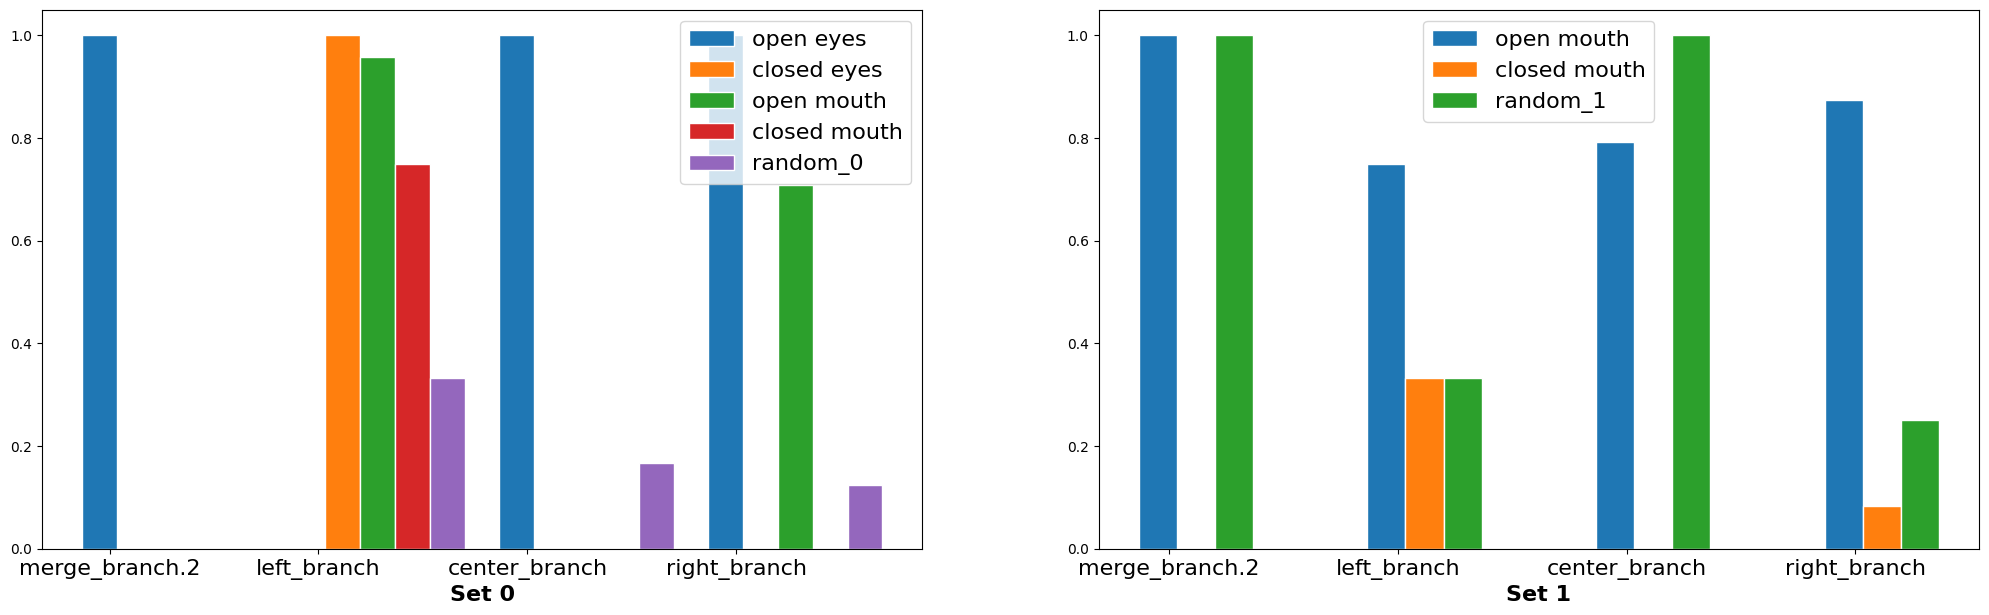

In [15]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)

## PAIN

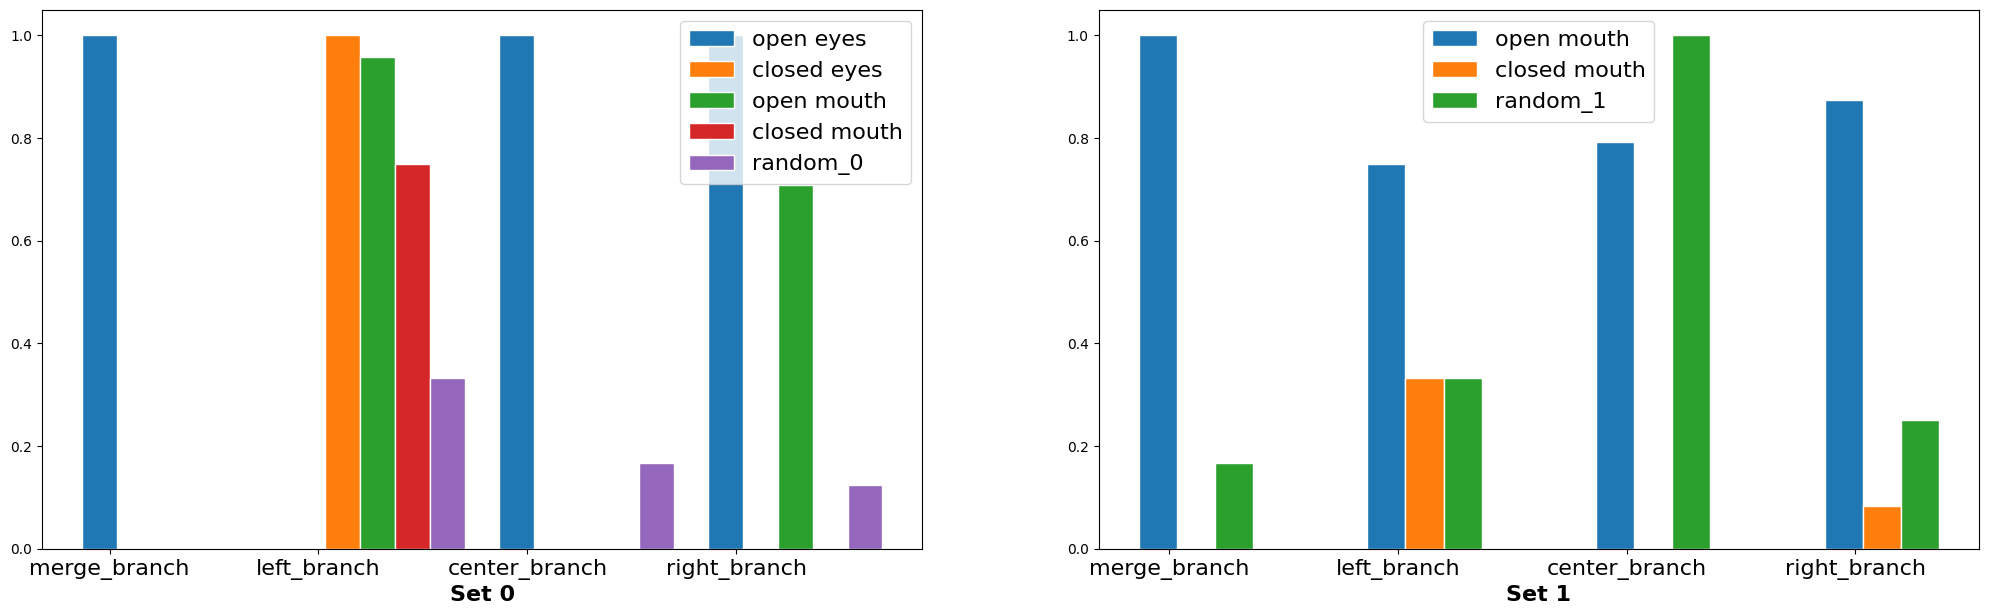

In [16]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)

In [17]:
n = 2

random_concepts = [assemble_concept('random_' + str(i+2), i+6) for i in range(0, n)]

print(random_concepts)

experimental_sets = [[open_eyes_concept, random_0_concept], [open_eyes_concept, random_1_concept]]
experimental_sets.extend([[open_eyes_concept, random_concept] for random_concept in random_concepts])

experimental_sets.append([random_0_concept, random_1_concept])
experimental_sets.extend([[random_0_concept, random_concept] for random_concept in random_concepts])

experimental_sets

[Concept(6, 'random_2'), Concept(7, 'random_3')]


[[Concept(1, 'open eyes'), Concept(4, 'random_0')],
 [Concept(1, 'open eyes'), Concept(5, 'random_1')],
 [Concept(1, 'open eyes'), Concept(6, 'random_2')],
 [Concept(1, 'open eyes'), Concept(7, 'random_3')],
 [Concept(4, 'random_0'), Concept(5, 'random_1')],
 [Concept(4, 'random_0'), Concept(6, 'random_2')],
 [Concept(4, 'random_0'), Concept(7, 'random_3')]]

In [18]:
def assemble_scores(scores, experimental_sets, idx, score_layer, score_type):
    score_list = []
    for concepts in experimental_sets:
        score_list.append(scores["-".join([str(c.id) for c in concepts])][score_layer][score_type][idx])
        
    return score_list

In [19]:
def get_pval(scores, experimental_sets, score_layer, score_type, alpha=0.05, print_ret=False):
    
    P1 = assemble_scores(scores, experimental_sets, 0, score_layer, score_type)
    P2 = assemble_scores(scores, experimental_sets, 1, score_layer, score_type)
    
    if print_ret:
        print('P1[mean, std]: ', format_float(np.mean(P1)), format_float(np.std(P1)))
        print('P2[mean, std]: ', format_float(np.mean(P2)), format_float(np.std(P2)))

    _, pval = ttest_ind(P1, P2)

    if print_ret:
        print("p-values:", format_float(pval))

    if pval < alpha:    # alpha value is 0.05 or 5%
        relation = "Disjoint"
        if print_ret:
            print("Disjoint")
    else:
        relation = "Overlap"
        if print_ret:
            print("Overlap")
        
    return P1, P2, format_float(pval), relation

In [20]:
scores = mytcav.interpret(pain_tensors, experimental_sets)

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\captum\_utils\models\linear_model\train.py:409: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


In [21]:
n = 4
def show_boxplots(layer, metric='sign_count'):

    def format_label_text(experimental_sets):
        concept_id_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_id_list

    n_plots = 2

    fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
    fs = 18
    for i in range(n_plots):
        esl = experimental_sets[i * n : (i+1) * n]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[i].set_ylim([0, 1])
        ax[i].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[i].boxplot([P1, P2], showfliers=True)

        ax[i].set_xticklabels(format_label_text(esl), fontsize=fs)

    plt.show()

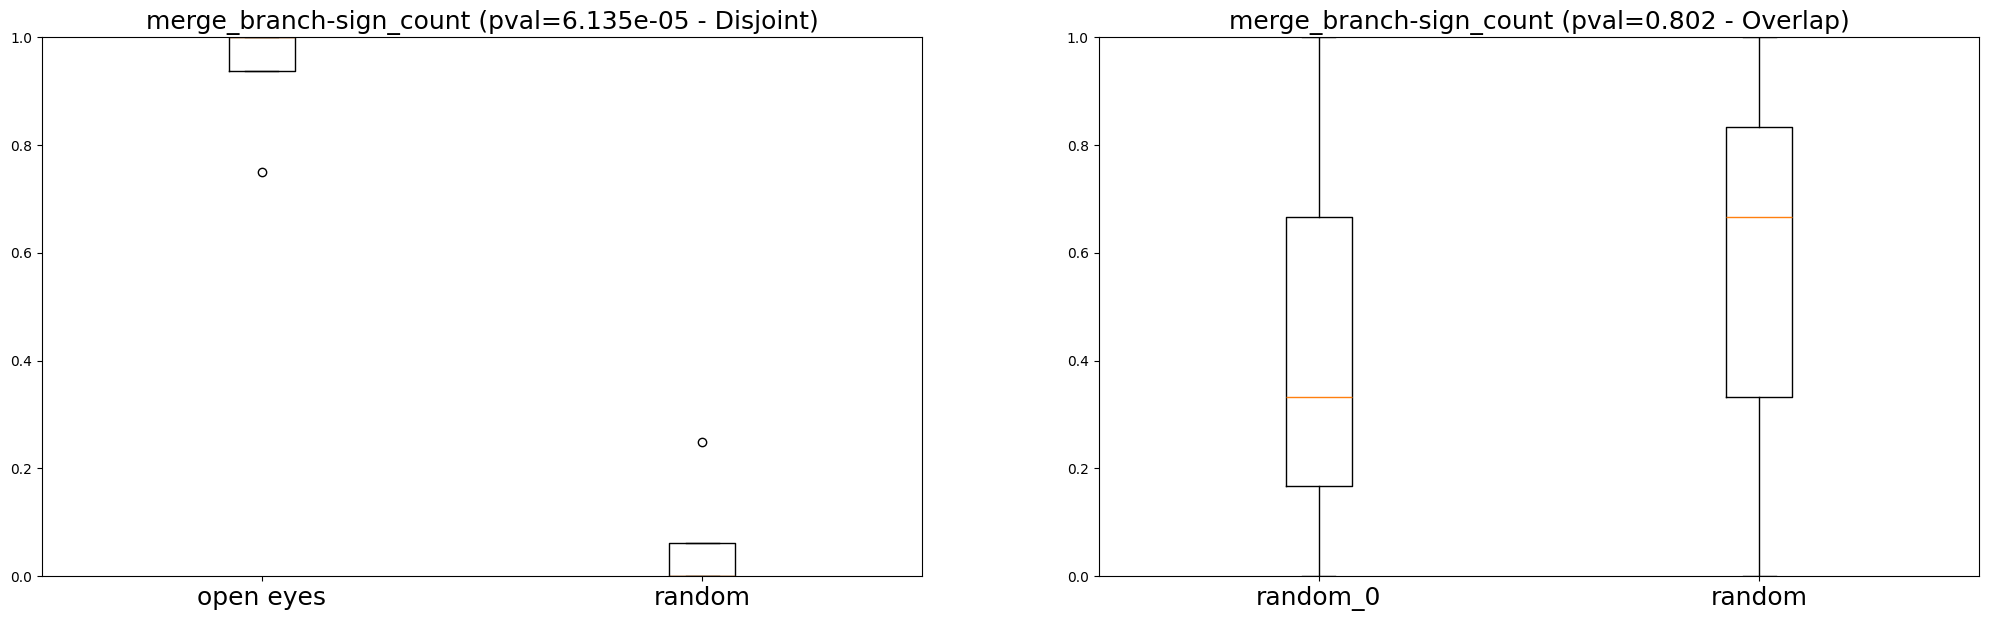

In [22]:
show_boxplots("merge_branch")

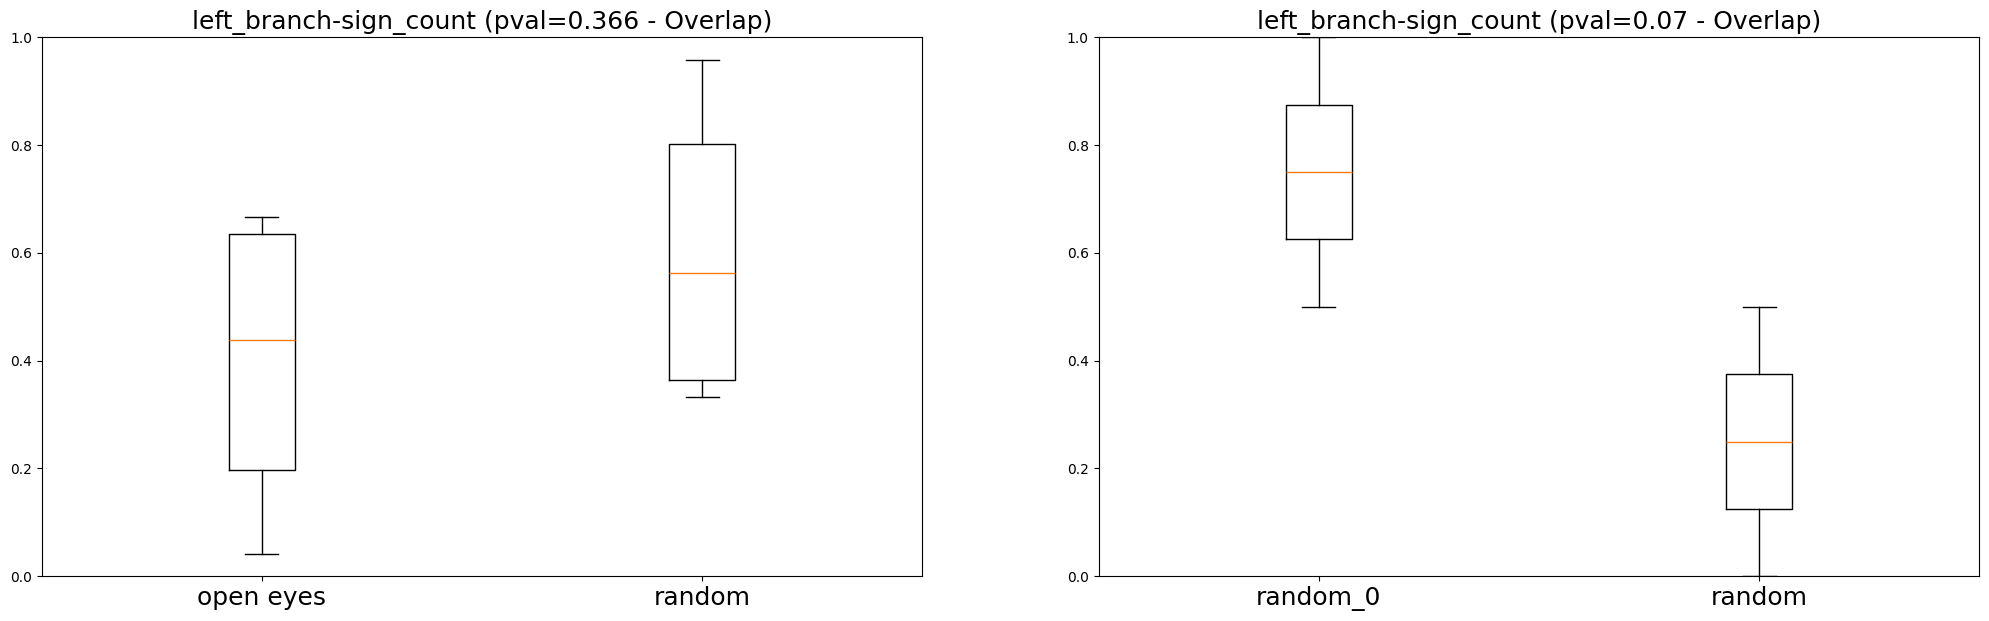

In [24]:
show_boxplots("left_branch")

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


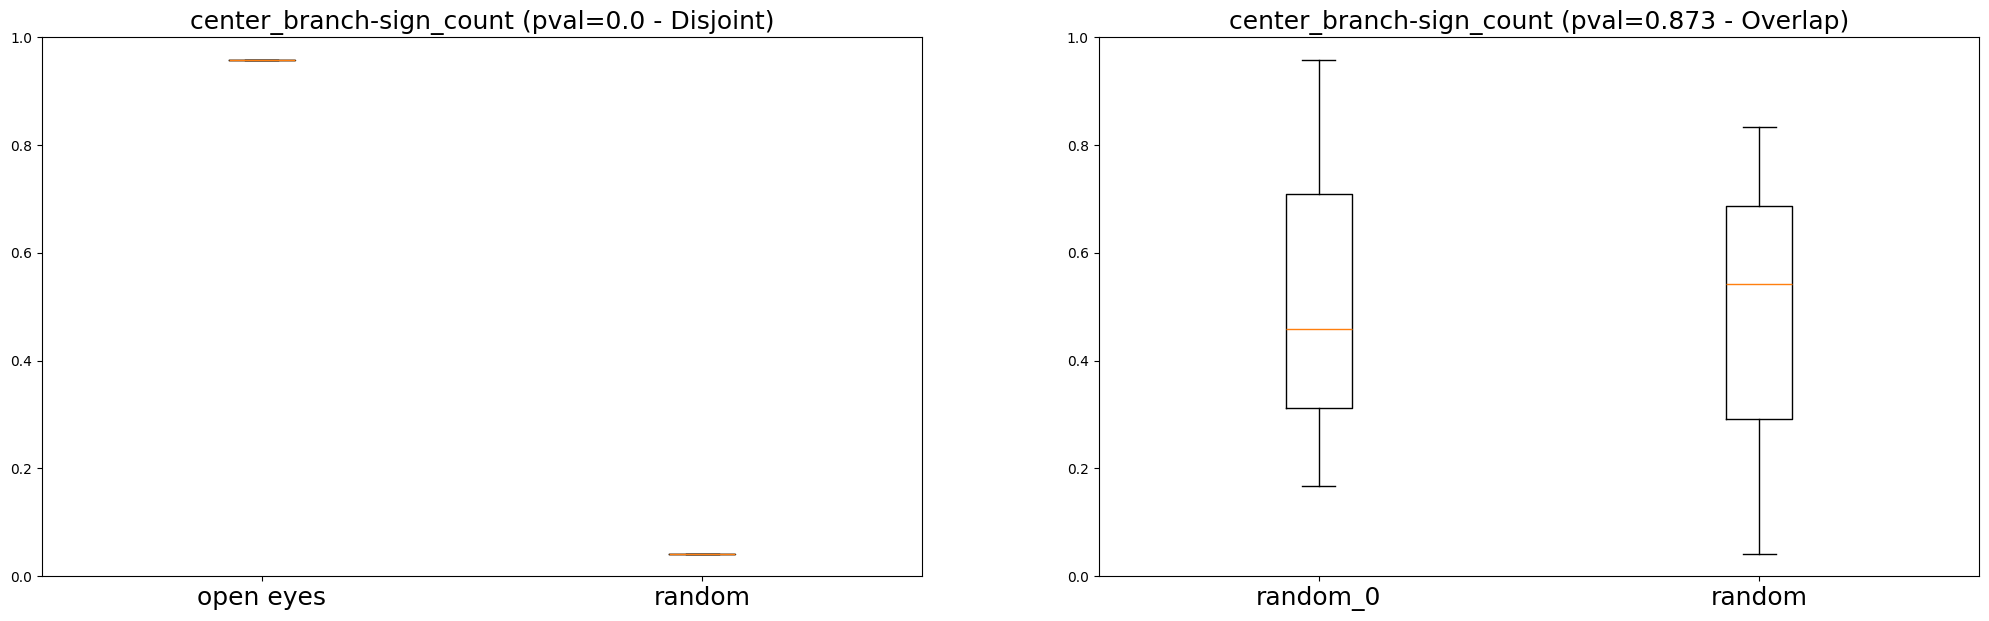

In [26]:
show_boxplots("center_branch")

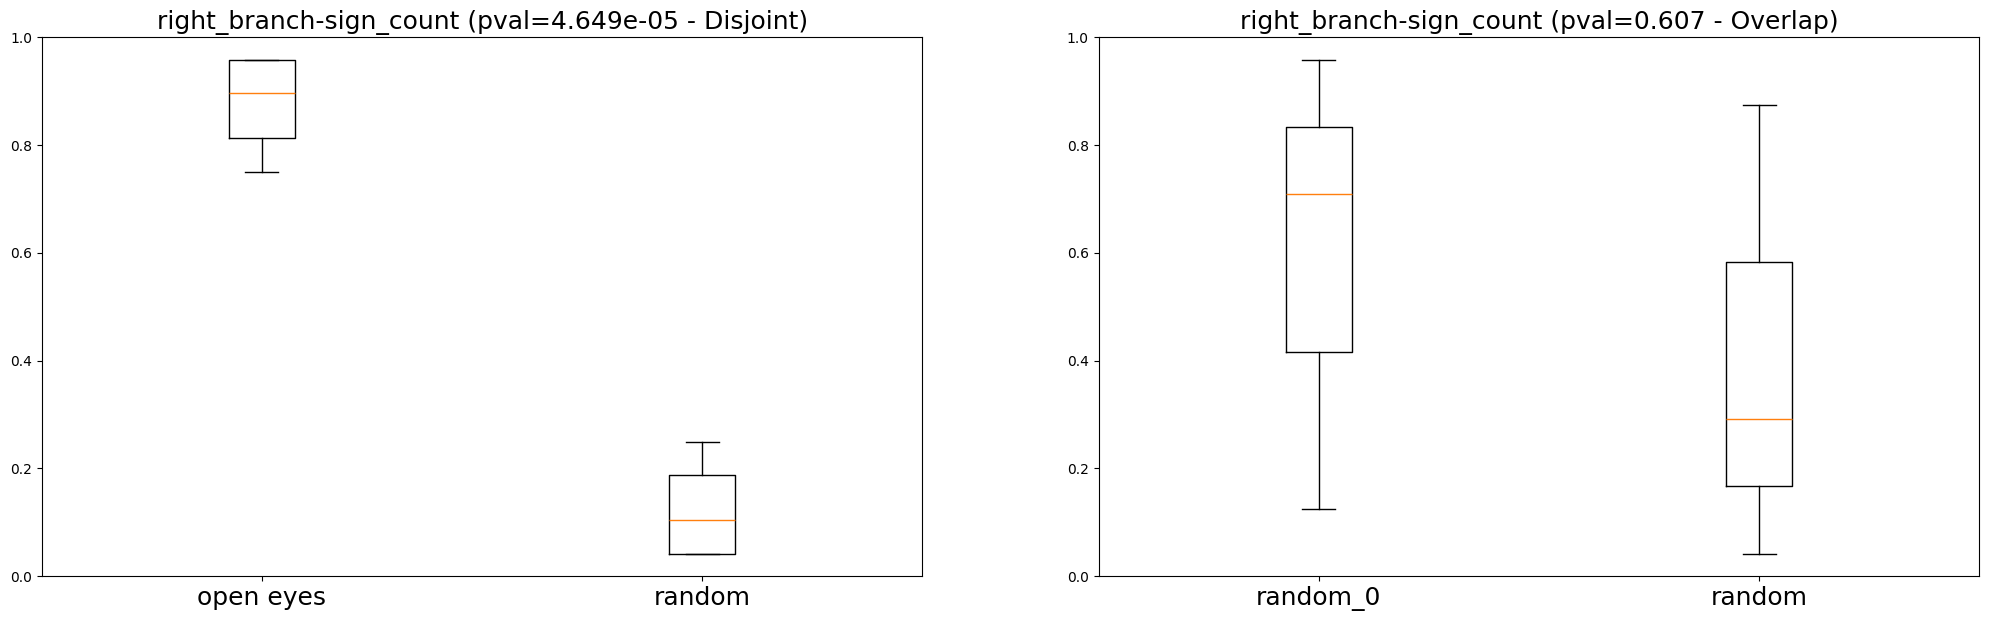

In [27]:
show_boxplots("right_branch")

# LIME With Facial Features

In [ ]:
from captum.attr import Lime
from XAI.metrics import  create_face_regions_masks
import pickle
from utils import resize_landmarks
import cv2
import torch
from captum.attr import visualization as viz


In [ ]:
with open(f'Datasets/DatasetFaces/Landmarks/{id}.pkl', 'rb') as f:
    landmarks = pickle.load(f)

test = create_face_regions_masks(landmarks)

test['eyes'] = test['right_eye'] + test['left_eye']
test['eyebrown'] = test['right_eyebrown'] + test['left_eyebrown']
test['nasolabial_fold'] = test['right_nasolabial_fold'] + test['left_nasolabial_fold']
test['cheek'] = test['right_cheek'] + test['left_cheek']

test.pop('right_eye')
test.pop('left_eye')
test.pop('right_eyebrown')
test.pop('left_eyebrown')
test.pop('right_nasolabial_fold')
test.pop('left_nasolabial_fold')
test.pop('right_cheek')
test.pop('left_cheek')
test.pop('outside')

features = np.zeros((img_size,img_size))

for i,mask in enumerate(test):
    features[np.where(cv2.resize(test[mask], (img_size,img_size), interpolation=cv2.INTER_NEAREST) == 1)] = i

features = np.stack([features] * 3, axis=0)

In [ ]:
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso


In [ ]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

def iter_combinations(*args, **kwargs):
    for i in range(2 **  len(test)):
        yield torch.tensor([int(d) for d in bin(i)[2:].zfill( len(test))]).unsqueeze(0)


lr_lime = Lime(
    model, 
    interpretable_model=SkLearnLasso(alpha=0.08),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance,
    perturb_func=iter_combinations
)


attrs = lr_lime.attribute(
    img_transformed,
    feature_mask=torch.tensor(features, dtype=torch.int64),
    n_samples=2 ** len(test),
    perturbations_per_eval=16,
    show_progress=True
).squeeze(0)

In [ ]:
def show_attr(attr_map):
    viz.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
        method='heat_map',
        sign='all',
        show_colorbar=True
    )
    
show_attr(attrs.cpu().detach())

# RISE

In [ ]:
from XAI import RISE
from models import NCNN, VGGFace
import torch
from dataloaders import presets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = "cuda"

In [ ]:
rise = RISE(model, input_size=(224,224), gpu_batch=10, device=device)

rise.generate_masks(1000, 8, 0.1)

In [ ]:
plt.imshow(rise.masks[0].cpu()[0])

In [ ]:
model.predict(img_transformed.unsqueeze(0).to(device))

In [ ]:
plt.imshow(mask.cpu())
plt.imshow(img.resize((224,224)), alpha=0.5)